##### Code From Previous Parts in PyTorch Workflow

In [6]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
## 1. Data: Making Classification Data And Getting It Ready

import sklearn
from sklearn.datasets import make_circles

# making 1000 samples
nSamples = 1000

# Creating circles using the make_circles import
X, y = make_circles(nSamples,
                    noise=0.02,
                    random_state= 246)

len(X), len(y)

(1000, 1000)

In [8]:
# Making DataFrame of circle data

import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], # first element in X to X1
                        "X2": X[:, 1], # second element in X to X2
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.984500,-0.231214,0
1,-0.057183,1.009841,0
2,-1.008487,-0.073464,0
3,-0.752918,-0.271420,1
4,0.537737,0.609730,1
5,-0.229706,0.772044,1
6,0.651580,0.538344,1
7,0.728727,-0.264977,1
8,-0.784848,0.160091,1
9,-1.011303,-0.107825,0


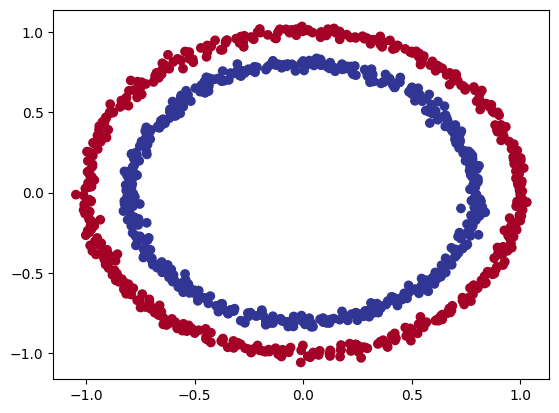

In [9]:
# Visualizing the Data
import matplotlib.pyplot as plt

plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap=plt.cm.RdYlBu) # type: ignore

# from this graph we want the model to predict whether the point is going to be a blue dot or a red dot from the graph and coordinates below: Binary Classification as the dots can only be blue or red
# Note: the data below is often referred to as a toy data set --> small enough to experiment with, but large enough to practice fundamentals 

In [10]:
# Turn Data Into Tensors

X = torch.from_numpy(X).type(torch.float) # converting to torch from numpy, and setting torch.float as default dtype for numpy if float64
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.9845, -0.2312],
         [-0.0572,  1.0098],
         [-1.0085, -0.0735],
         [-0.7529, -0.2714],
         [ 0.5377,  0.6097]]),
 tensor([0., 0., 0., 1., 1.]))

In [11]:
# Splitting the data into training and testing sets
# Since the data is randomly positioned, it it possible in this case to split the data set randomly

from sklearn.model_selection import train_test_split

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
XTrain, XTest, yTrain, yTest = train_test_split(X,
                                                y,
                                                test_size=0.2, # test_size = 0.2 means 20 percent will be test, and 80 percent will be train
                                                random_state=246) # random state is equivalent to the random seed function in pytorch

# The random seed in pytorch only works for pytorch method

len(XTrain), len(XTest), len(yTrain), len(yTest)

(800, 200, 800, 200)

In [12]:
nSamples

1000

In [13]:
# 1. Construct a model that subclasses nn.Module

class CircleModel(nn.Module): # subclassing nn.Module here
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear() layers
        self.layer1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features, so the next layer has to have the same features in the input features in order to match the two layers
        self.layer2 = nn.Linear(in_features=5, out_features=1) # the last layer is the output layer, and the current in features of the layer have to be the same as the outputs of the previous layer, otherwise there will be 
                                                               # shape mismatch errors (takes in 5 features from the previous layer and outputs a single feature to be the same shape as y)
    
    # 3. Defining a forward() method that outline the forward path
    def forward(self, x):
        return self.layer2(self.layer1(x)) # passing the value of layer1 with x to layer2 (reverse order): x -> layer1 -> layer2 -> output
    
# 4. Instantiate an instance of the model class
model0 = CircleModel().to(device)
model0

CircleModel(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# Replicating the model using nn.Sequential
model0 = nn.Sequential(
    nn.Linear(in_features=2, out_features= 5),
    nn.Linear(in_features= 5, out_features= 1) # steps through the model on its own rather than creating a forward function
).to(device)
# useful for simple and straight forward models that step through each layer one by one, but less useful when the models get more complicated

model0, next(model0.parameters()).device

(Sequential(
   (0): Linear(in_features=2, out_features=5, bias=True)
   (1): Linear(in_features=5, out_features=1, bias=True)
 ),
 device(type='cuda', index=0))

In [15]:
model0.state_dict() # created weights and biases based on the in and out features of the parameters of the model

# 2 * 5 equals 10 weight tensors: layer1.weight

OrderedDict([('0.weight',
              tensor([[-0.1871, -0.4853],
                      [-0.2190,  0.3667],
                      [ 0.6866,  0.5896],
                      [ 0.1492,  0.6442],
                      [-0.4042,  0.5805]], device='cuda:0')),
             ('0.bias',
              tensor([-0.3426, -0.6826, -0.5187, -0.6700,  0.6681], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0009, -0.3072,  0.0388,  0.3635, -0.1768]], device='cuda:0')),
             ('1.bias', tensor([-0.2890], device='cuda:0'))])

In [16]:
# Making Predictions Using The Model Without Training

untrainedPredictions = model0(XTest.to(device))

print(f"Length Of Predictions: {len(untrainedPredictions)}, Shape:{untrainedPredictions.shape}")
print(f"Length Of Test Samples: {len(XTest)}, Shape: {XTest.shape}")

print(f"\n First 10 Predictions: {torch.round(untrainedPredictions[:10])}") # had to use torch.round() as the values were floats instead of ints
print(f"\n First 10 Labels: {yTest[:10]}")

# As shown in the predictions, without any training the results are abysmal 

Length Of Predictions: 200, Shape:torch.Size([200, 1])
Length Of Test Samples: 200, Shape: torch.Size([200, 2])

 First 10 Predictions: tensor([[-0.],
        [-1.],
        [-1.],
        [-0.],
        [-1.],
        [-1.],
        [-1.],
        [-0.],
        [-1.],
        [-0.]], device='cuda:0', grad_fn=<RoundBackward0>)

 First 10 Labels: tensor([1., 1., 1., 1., 1., 0., 0., 0., 1., 1.])


In [17]:
# creating loss function with torch.nn.BCEWithLogitsLoss (binary cross entropy)

# BCELoss - requires inputs to have already gone through the sigmoid activation function before inputting to BCELoss
lossFunction = nn.BCEWithLogitsLoss() # with sigmoid activation function built in (torch.sigmoid) - combines sigmoid loss with BCE loss, and is more numerically stable

optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr = 0.1)

In [18]:
# Calculating accuracy: out of 100 examples, what percentage will the model get right?

def accuracy(yTrue, yPred):
    correct = torch.eq(yTrue, yPred).sum().item() # torch.eq() tests to see how many values between the two tensors passed in are equal to each other
    acc = (correct/len(yPred)) * 100 # accuracy formula
    return acc

In [19]:
# Step 1: Looking at the first 5 outputs of the forward pass on the test data (in logits)

model0.eval()
with torch.inference_mode():
    yLogits = model0(XTest.to(device))[:5]

yLogits
# upon getting passed the test sets, the data will first go through the linear layer, where the linear formula will be applied

tensor([[-0.2942],
        [-0.6252],
        [-0.5865],
        [-0.3153],
        [-0.5514]], device='cuda:0')

In [20]:
yTest[:5]
# in order to calculate the accuracy of the model, the output of the model has to be in the same format as the test data

tensor([1., 1., 1., 1., 1.])

In [21]:
# Step 2: using the sigmoid activation on the model logits(yLogits) to turn them into prediction probabilities
yPredProb = torch.sigmoid(yLogits)

yPredProb

tensor([[0.4270],
        [0.3486],
        [0.3574],
        [0.4218],
        [0.3655]], device='cuda:0')

For the prediction values, its required to perform a style-range rounding such that:
* yPredProb >= 0.5: y = 1 (class 1)
* yPredProb < 0.5: y = 0 (class 0)

In [22]:
# Step 3: Rounding the prediction probabilities

torch.round(yPredProb)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [23]:
yPrediction = torch.round(yPredProb) # Finding the predicted labels

# In full finding the predicted labels as well (logits -> pred probability -> pred labels)
yPredLabels = torch.round(torch.sigmoid(model0(XTest.to(device))[:5]))

# checking for equality
print(torch.eq(yPrediction.squeeze(), yPredLabels.squeeze())) # squeezing to get rid of the extra dimension

yPrediction.squeeze() # getting rid of the extra dimension

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

In [24]:
torch.manual_seed(246) # reproducibility, alternative to manual seed is torch.seed(int)

torch.cuda.manual_seed(246)

# setting number of epochs
epochs = 100

XTrain, yTrain = XTrain.to(device), yTrain.to(device)
XTest, yTest = XTest.to(device), yTest.to(device)

# building training and evaluation loop
for epoch in range(epochs):
    ### Training
    model0.train()

    ### Forward Pass
    yLogits = model0(XTrain).squeeze()
    yPrediction = torch.round(torch.round(yLogits)) # turning logits -> pred probabilities -> pred labels

    ### Calculate Loss/Accuracy

    # loss = lossFunction(torch.sigmoid(yLogits),
    #                     yTrain) # nn.BCELoss expects prediction probabilities as input

    loss = lossFunction(yLogits, 
                        yTrain) # nn.BCEWithLogitsLoss expects logits as input
    
    acc = accuracy(yTrue=yTrain,
                   yPred=yPrediction)
    
    ### Optimizer Zero Grad
    optimizer.zero_grad()

    ### Loss Backward
    loss.backward()

    ### Optimizer Step (gradient descent)
    optimizer.step()

    ### Testing
    model0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        testLogits = model0(XTest).squeeze()
        testPred = torch.round(torch.sigmoid(testLogits))

        # 2. Calculate test loss/acc
        testLoss = lossFunction(testLogits,
                                yTest)
        
        testAcc = accuracy(yTrue=yTest,
                           yPred=testPred)
        
    # Printing
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss {loss:.3f}, Acc: {acc:.3f} | Test Loss: {testLoss:.3f}, Test Acc: {testAcc:.3f}")
        
# with an accuracy of 50% the model is about the same as guessing or a coin flip

Epoch: 0 | Loss 0.720, Acc: 26.875 | Test Loss: 0.724, Test Acc: 49.000
Epoch: 10 | Loss 0.699, Acc: 50.250 | Test Loss: 0.703, Test Acc: 49.000
Epoch: 20 | Loss 0.694, Acc: 50.250 | Test Loss: 0.698, Test Acc: 43.500
Epoch: 30 | Loss 0.693, Acc: 50.250 | Test Loss: 0.697, Test Acc: 44.500
Epoch: 40 | Loss 0.693, Acc: 50.250 | Test Loss: 0.696, Test Acc: 47.500
Epoch: 50 | Loss 0.693, Acc: 50.250 | Test Loss: 0.696, Test Acc: 48.500
Epoch: 60 | Loss 0.693, Acc: 50.250 | Test Loss: 0.696, Test Acc: 46.500
Epoch: 70 | Loss 0.693, Acc: 50.250 | Test Loss: 0.696, Test Acc: 46.500
Epoch: 80 | Loss 0.693, Acc: 50.250 | Test Loss: 0.695, Test Acc: 46.500
Epoch: 90 | Loss 0.693, Acc: 50.250 | Test Loss: 0.695, Test Acc: 46.500


In [25]:
import requests # using this import it is possible to import helper functions from websites such as github
from pathlib import Path

# Downloading helper functions from the Learn Pytorch repo (if its not already downloaded)

if Path("helper_functions.py").is_file():
    print("helper_functions.py already is in the program, skipping download")
else:
    print("Downloading: helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)


# Checking to see if it works
from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already is in the program, skipping download


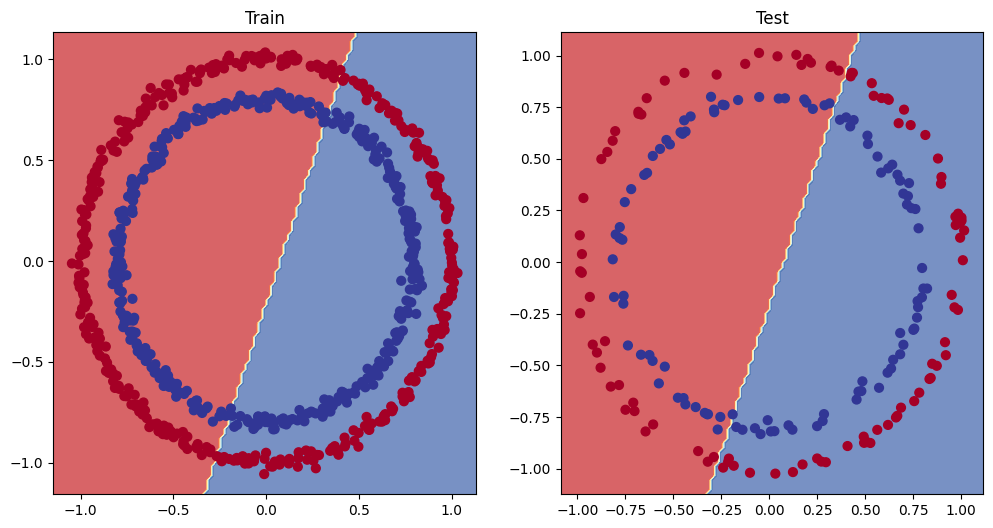

In [26]:
plt.figure(figsize=(12,6))

# Training Data
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, XTrain, yTrain)

# Testing Data
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, XTest, yTest)

# The model is trying to draw a straight line through the data, but the data is a circle
# This might be due to the fact that the current model is only made using linear layers which will draw a straight line

In [27]:
### Creating A New Model With Mode Layers And Hidden Units
# making use of torch.utils.tensorboard

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features= 2, out_features= 10)
        self.layer2 = nn.Linear(in_features= 10, out_features= 10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer1(x) # z is the same as logits from before(represented)
        # z = self.layer2(z) # overriding z with the itself, as it has the values from the previous z and the input to the forward function of x
        # z = self.layer3(z) 
        # return z
        return self.layer3(self.layer2(self.layer1(x))) # this is a faster way of writing operations, using speedups behind the scenes
    
model1 = CircleModelV1().to(device)
model1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [28]:
model1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.4104,  0.6807],
                      [ 0.1293, -0.1909],
                      [ 0.3493,  0.2681],
                      [ 0.5395,  0.3830],
                      [ 0.3973, -0.4047],
                      [-0.5648,  0.0325],
                      [-0.2648,  0.5451],
                      [ 0.1700,  0.6153],
                      [-0.1313, -0.2750],
                      [-0.1690, -0.0811]], device='cuda:0')),
             ('layer1.bias',
              tensor([-0.5874, -0.5543,  0.1747, -0.2818, -0.4004, -0.6020,  0.4379,  0.0482,
                       0.4882, -0.6425], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.1222,  0.2508,  0.2917, -0.2392, -0.1158,  0.2415, -0.0073,  0.2798,
                        0.0488,  0.1619],
                      [ 0.0920,  0.2590, -0.3049,  0.0444,  0.1477,  0.2929, -0.0796, -0.2931,
                       -0.2641,  0.2708],
                      [-0.1745, -0.0197, 

In [29]:
# loss function

lossFn = nn.BCEWithLogitsLoss()

# Optimizer
opt = torch.optim.SGD(params=model1.parameters(),
                            lr = 0.1)

In [30]:
# Training and evaluation loop

torch.manual_seed(246)
torch.cuda.manual_seed(246)

epochs = 1000

XTrain, yTrain = XTrain.to(device), yTrain.to(device)
XTest, yTest = XTest.to(device), yTest.to(device)

for epoch in range(epochs):
    model1.train()
    
    yLogits = model1.forward(XTrain).squeeze()

    yPred = torch.round(torch.sigmoid(yLogits))

    loss = lossFunction(yLogits, yTrain)

    acc = accuracy(yTrue=yTrain,
                   yPred= yPred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model1.eval()
    with torch.inference_mode():
        testLogits = model1(XTest).squeeze()
        testPred = torch.round(torch.sigmoid(testLogits))

        testLoss = lossFunction(testLogits, yTest)

        testAcc = accuracy(yTrue=yTest,
                           yPred= testPred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {testLoss:.5f} | Test Acc: {testAcc:.2f}%")

Epoch: 0 | Loss: 0.70231 | Acc: 50.25% | Test Loss: 0.70720 | Test Acc: 49.00%
Epoch: 100 | Loss: 0.70231 | Acc: 50.25% | Test Loss: 0.70720 | Test Acc: 49.00%
Epoch: 200 | Loss: 0.70231 | Acc: 50.25% | Test Loss: 0.70720 | Test Acc: 49.00%
Epoch: 300 | Loss: 0.70231 | Acc: 50.25% | Test Loss: 0.70720 | Test Acc: 49.00%
Epoch: 400 | Loss: 0.70231 | Acc: 50.25% | Test Loss: 0.70720 | Test Acc: 49.00%
Epoch: 500 | Loss: 0.70231 | Acc: 50.25% | Test Loss: 0.70720 | Test Acc: 49.00%
Epoch: 600 | Loss: 0.70231 | Acc: 50.25% | Test Loss: 0.70720 | Test Acc: 49.00%
Epoch: 700 | Loss: 0.70231 | Acc: 50.25% | Test Loss: 0.70720 | Test Acc: 49.00%
Epoch: 800 | Loss: 0.70231 | Acc: 50.25% | Test Loss: 0.70720 | Test Acc: 49.00%
Epoch: 900 | Loss: 0.70231 | Acc: 50.25% | Test Loss: 0.70720 | Test Acc: 49.00%


In [31]:
# making linear data (smaller problem)

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# creating data
XRegression = torch.arange(start, end, step).unsqueeze(dim= 1)
yRegression = weight * XRegression + bias

print(len(XRegression))

XRegression[:5], yRegression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [32]:
# Creating Training/Test Splits
trainSplit = int(0.8 * len(XRegression))

XTrainRegression, yTrainRegression = XRegression[:trainSplit], yRegression[:trainSplit]
XTestRegression, yTestRegression = XRegression[trainSplit:], yRegression[trainSplit:]

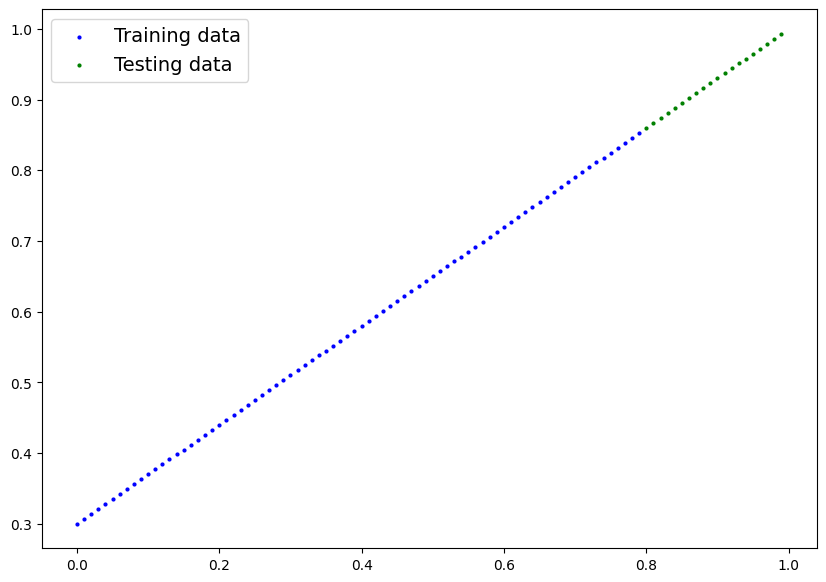

In [33]:
plot_predictions(train_data=XTrainRegression,
                 train_labels= yTrainRegression,
                 test_data= XTestRegression,
                 test_labels=yTestRegression)

In [34]:
model1
# seeing if the model can learn on a straight line dataset, so the model can be improved on a non straight line dataset

# in order to fit the data to the model, the first layer's in features has to be changed, as the linear data set only has one x variable(or only one input)

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
### Adjusting model1 to fit a single line

model2 = nn.Sequential(
    nn.Linear(in_features= 1, out_features= 10),
    nn.Linear(in_features= 10, out_features= 10),
    nn.Linear(in_features= 10, out_features= 1)
).to(device)

model2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [36]:
# Loss and optimizer
lossFn = nn.L1Loss()

optimizer = torch.optim.SGD(params= model2.parameters(),
                            lr = 0.01)

In [37]:
# Training the model

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# number of epochs
epochs = 1000

# putting the data to the target device
XTrainRegression, yTrainRegression = XTrainRegression.to(device), yTrainRegression.to(device)
XTestRegression, yTestRegression = XTestRegression.to(device), yTestRegression.to(device)

# Training loop

for epoch in range(epochs):
    yPred = model2(XTrainRegression)
    loss = lossFn(yPred, yTrainRegression)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model2.eval()
    with torch.inference_mode():
        testPred = model2(XTestRegression)
        testLoss = lossFn(testPred, yTestRegression)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss {testLoss:.5f}")

# since the loss is decreasing, it means that the model is indeed learning something

Epoch: 0 | Loss: 0.72135 | Test Loss 0.92567
Epoch: 100 | Loss: 0.00636 | Test Loss 0.00540
Epoch: 200 | Loss: 0.02925 | Test Loss 0.00172
Epoch: 300 | Loss: 0.02651 | Test Loss 0.00367
Epoch: 400 | Loss: 0.02295 | Test Loss 0.00481
Epoch: 500 | Loss: 0.02128 | Test Loss 0.00401
Epoch: 600 | Loss: 0.02059 | Test Loss 0.00490
Epoch: 700 | Loss: 0.02063 | Test Loss 0.00446
Epoch: 800 | Loss: 0.02070 | Test Loss 0.00485
Epoch: 900 | Loss: 0.01977 | Test Loss 0.00391


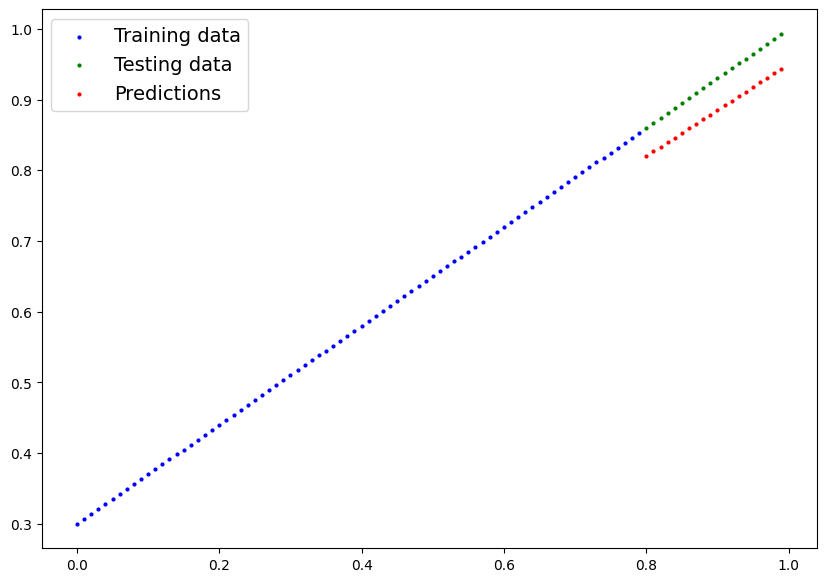

In [38]:
# Making predictions by turning on evaluation mode

model2.eval()

with torch.inference_mode():
    yPred = model2(XTestRegression)


plot_predictions(train_data= XTrainRegression.cpu(),
                 train_labels= yTrainRegression.cpu(),
                 test_data= XTestRegression.cpu(),
                 test_labels= yTestRegression.cpu(),
                 predictions= yPred.cpu())

# Since the red line(predictions are very close to the green line(test data), its evident that the model can learn)

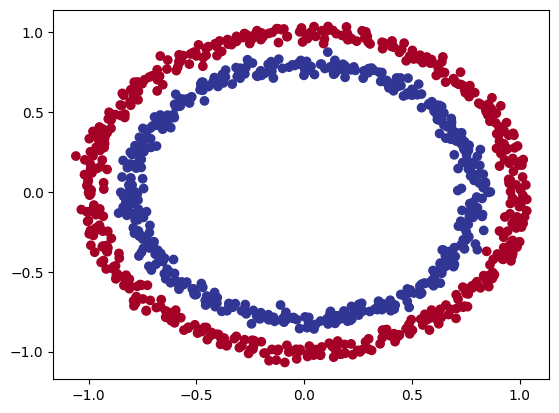

In [39]:
# Recreating non-linear data (red and blue circles)

nSamples = 1000

X, y = make_circles(nSamples,
                    noise= 0.03,
                    random_state= 42)

plt.scatter(X[:, 0], X[:, 1], c = y, cmap= plt.cm.RdYlBu) # type: ignore

In [40]:
# converting the data to tensors, in order to train and test the model, and to use the train test splits

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# train test split
XTrain, XTest, yTrain, yTest = train_test_split(X, y,
                                                test_size= 0.2,
                                                random_state= 42)

XTrain[:5], yTrain[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [41]:
### Building a model with non-linearity: which are graphs that aren't straight lines or in other words just a curved line
# and with non-linear activation 

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features= 2, out_features= 10)
        self.layer2 = nn.Linear(in_features= 10, out_features= 10)
        self.layer3 = nn.Linear(in_features= 10, out_features= 1)
        self.relu = nn.ReLU() # (rectified linear unit) --> non linear activation function

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x))))) # have to call the relu function first, before each individual layer can be called
    
model3 = CircleModelV2()
model3 # relu function does not have any parameters to optimize

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [42]:
# Writing Training And Testing Code 
### Setting up loss and optimizer

lossF = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model3.parameters(),
                            lr = 0.1)

In [43]:
### Training Models With Non-Linearity 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Converting all data to the target device

model3.to(device)

XTrain, yTrain = XTrain.to(device), yTrain.to(device)
XTest, yTest = XTest.to(device), yTest.to(device)

epochs = 1000

for epoch in range(epochs):
    # 1. Forward pass
    yLogits = model3(XTrain).squeeze()
    yPred = torch.round(torch.sigmoid(yLogits))

    # 2. Calculate the loss
    loss = lossFn(yLogits, yTrain)
    acc = accuracy(yTrue= yTrain,
                   yPred= yPred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward loss
    loss.backward()

    # 5. Optimizer Step
    optimizer.step()

    ### Testing
    model3.eval()

    with torch.inference_mode():
        testLogits = model3(XTest).squeeze()
        testPred = torch.round(torch.sigmoid(testLogits))

        testLoss = lossF(testLogits, yTest)
        testAcc = accuracy(yTrue=yTest,
                           yPred= testPred)
        
    # Print Statements
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.3f}, Acc: {acc:.2f} | Test Loss: {testLoss:.4f}, Test Acc: {testAcc}")

# as can be seen with the accuracy the model is now learning
# and it can draw lines to separate and predict the circles

Epoch: 0 | Loss: 0.499, Acc: 50.00 | Test Loss: 0.6931, Test Acc: 50.0
Epoch: 100 | Loss: 0.493, Acc: 50.38 | Test Loss: 0.6897, Test Acc: 50.0
Epoch: 200 | Loss: 0.483, Acc: 50.62 | Test Loss: 0.6857, Test Acc: 50.0
Epoch: 300 | Loss: 0.458, Acc: 51.00 | Test Loss: 0.6788, Test Acc: 51.0
Epoch: 400 | Loss: 0.390, Acc: 52.25 | Test Loss: 0.6715, Test Acc: 52.0
Epoch: 500 | Loss: 0.280, Acc: 52.25 | Test Loss: 0.6197, Test Acc: 56.00000000000001
Epoch: 600 | Loss: 0.345, Acc: 50.00 | Test Loss: 0.5862, Test Acc: 57.99999999999999
Epoch: 700 | Loss: 0.135, Acc: 61.62 | Test Loss: 0.5646, Test Acc: 62.5
Epoch: 800 | Loss: 0.206, Acc: 88.38 | Test Loss: 0.7008, Test Acc: 50.0
Epoch: 900 | Loss: 0.162, Acc: 80.38 | Test Loss: 0.6322, Test Acc: 50.0


In [44]:
### Evaluating Models Trained With Non-Linear Activation Functions:

model3.eval()

with torch.inference_mode():
    yPred = torch.round(torch.sigmoid(model3(XTest))).squeeze()

yPred[:10], yTest[:10]
# just checking that they have the same shape (making sure that the two tensors are the same) and are on the same device

(tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

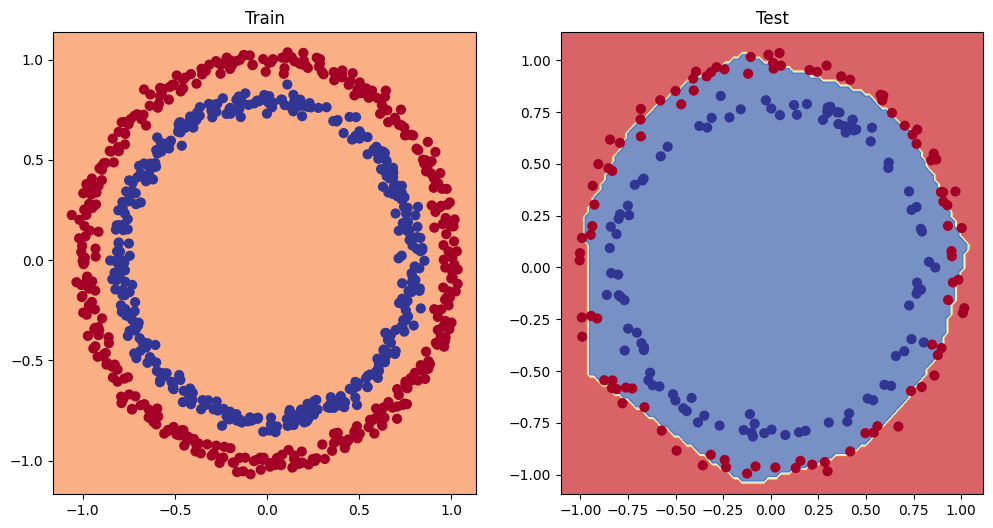

In [45]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1) # subplot: (row, column, index)
plt.title("Train")
plot_decision_boundary(model1, XTrain, yTrain) # no non-linearity (can't draw lines that aren't straight)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model3, XTest, yTest) # model 3 has non-linearity (draws lines that aren't straight)

In [46]:
### Replicating non-linear activation functions with pure Pytorch

A = torch.arange(-10, 10, 1) # (lower bound, upper bound, step)
A.dtype, A

(torch.int64,
 tensor([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
           4,   5,   6,   7,   8,   9]))

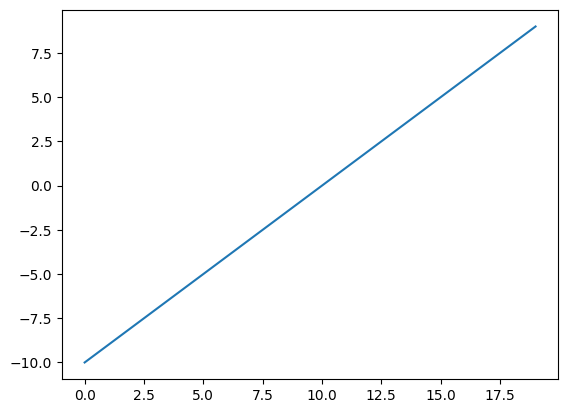

In [47]:
plt.plot(A) # perform relu function on the straight line

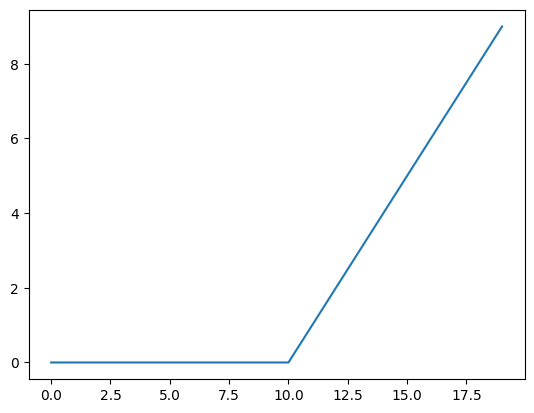

In [48]:
plt.plot(torch.relu(A)) # the relu function returns the max of zero and x (nn.relu)

In [49]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

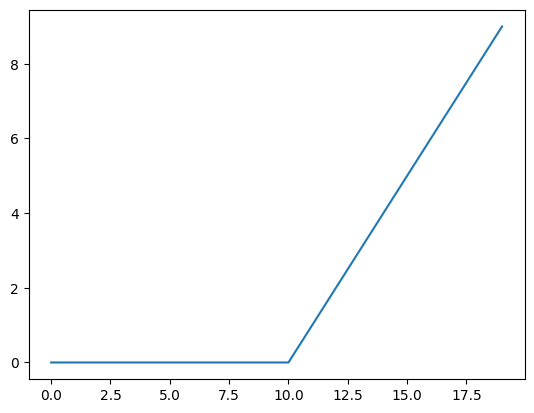

In [50]:
# plot custom relu activation function

plt.plot(relu(A))
# is the exact same as the nn.Relu function built from only using pytorch's max function

In [51]:
# Replicating sigmoid function from pytorch: https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

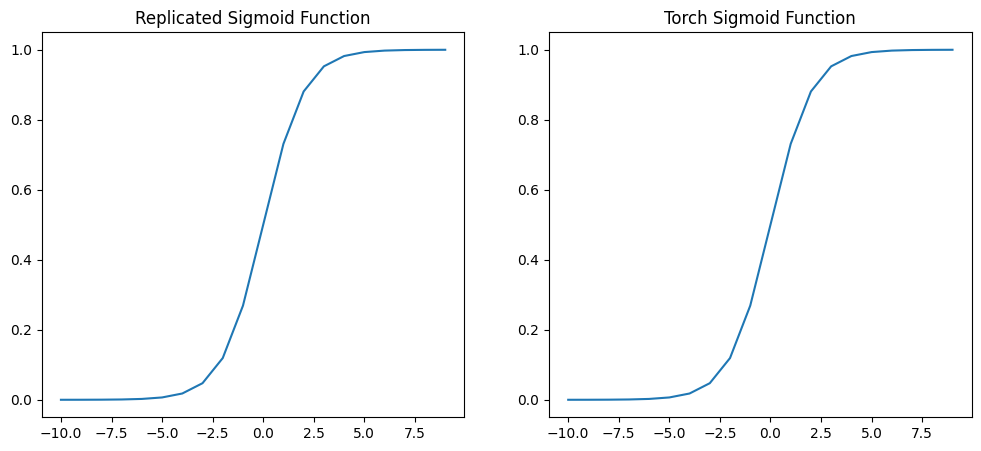

In [52]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5)) # type: ignore

# Plot the replicated sigmoid function
ax1.plot(A, sigmoid(A))
ax1.set_title('Replicated Sigmoid Function')

# Plot the Torch function
ax2.plot(A, torch.sigmoid(A))
ax2.set_title('Torch Sigmoid Function')

# Display the plots
plt.show()

# As can be seen the replicated functions works the same as the torch.nn functions
# Pytorch's models can run on the GPU and are error tested

1. Creating Multiclass Classification Toy Data

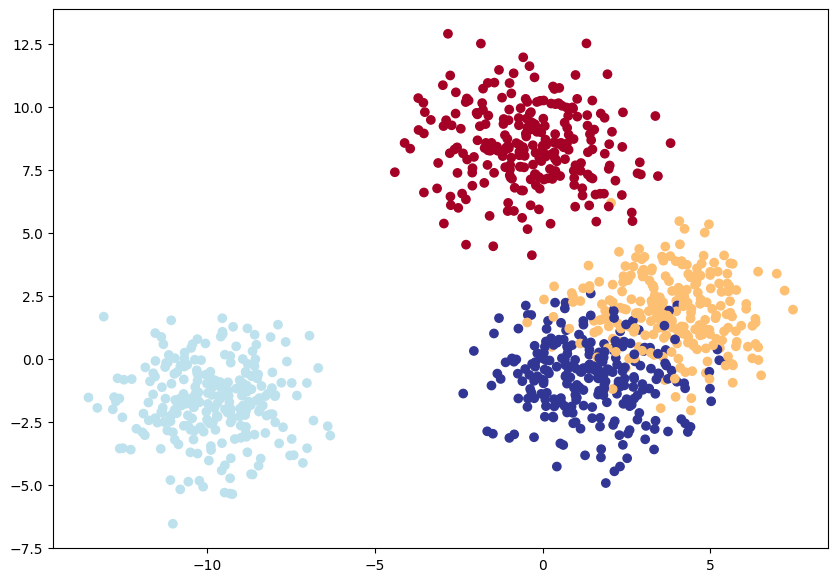

In [53]:
# Creating a toy dataset
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html

# setting the hyper parameters from the scikit learn documentation
classNum = 4
featureNum = 2
randomSeed = 246

# Creating multiclass data
XBlob, yBlob = make_blobs(n_samples=1000, # type: ignore
                          n_features= featureNum,
                          centers= classNum,
                          cluster_std= 1.5,
                          random_state= randomSeed)

# turning the data into tensors
XBlob = torch.from_numpy(XBlob).type(torch.float)
yBlob = torch.from_numpy(yBlob).type(torch.LongTensor) # type: ignore

# splitting the data that are now tensors into the test and train datasets
XBlobTrain, XBlobTest, yBlobTrain, yBlobTest = train_test_split(XBlob,
                                                                yBlob,
                                                                test_size= 0.2,
                                                                random_state= randomSeed)

# plotting the data
plt.figure(figsize= (10, 7))
plt.scatter(XBlob[:, 0], XBlob[:, 1], c=yBlob, cmap=plt.cm.RdYlBu) # type: ignore

# the output layer shape has to correspond to the number of different classes in the data, in this case there would have to be 4 output layers
# which can be seen by calling yBlobTrain[:]

2. Building a multi-class classification model in Pytorch

In [54]:
# Create device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"

In [55]:
# Building a multiclass classification model

class blobModel(nn.Module):
    def __init__(self, inputFeatures, outputFeatures, hiddenUnits = 8):

        super().__init__()
        
        self.linearLayerStack = nn.Sequential(
            nn.Linear(in_features= inputFeatures, out_features= hiddenUnits),
            #nn.ReLU(), # for non-linearity
            nn.Linear(in_features= hiddenUnits, out_features= hiddenUnits),
            #nn.ReLU(),
            nn.Linear(in_features= hiddenUnits, out_features= outputFeatures)
        )

    def forward(self, x):
        return self.linearLayerStack(x) # instead of having to pass the x values through each layer, using the nn.Sequential it is possible to stack layers on top of each other
                                        # and it is possible to just pass the value to the stack and have all the layers passed through automatically

model4 = blobModel(inputFeatures= 2,
                   outputFeatures= 4,
                   hiddenUnits= 8).to(device)

model4

blobModel(
  (linearLayerStack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

3. Creating a loss and optimizer for multiclass classification model

In [56]:
# Loss Function - CrossEntropyLoss: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

lossFn = nn.CrossEntropyLoss()

# Optimizer - SGD
optimizer = torch.optim.SGD(params=model4.parameters(),
                            lr= 0.01) # lr is a changeable hyper parameters

4. Getting prediction probabilities
- To evaluate, train and test the model, first convert the models outputs (logits) into prediction probabilities and then to prediction labels

Logits (raw output of the model) -> Pred Probs (use torch.softmax) -> Pred Labels (taking the argmax of the pred probs)

In [57]:
model4.eval()

with torch.inference_mode():
    yLogits = model4(XBlobTest.to(device))

yLogits[:10]

tensor([[-0.3811, -1.4505, -0.6084,  0.6051],
        [-0.2099, -0.4330, -0.2728, -0.0255],
        [-1.2864, -0.2878, -1.4387, -0.9889],
        [-0.4590, -0.4786, -0.5540, -0.1888],
        [-1.0512, -0.5774, -1.2211, -0.5842],
        [ 3.6282, -0.1326,  4.0020,  2.7930],
        [ 3.1071, -0.0616,  3.4377,  2.3261],
        [ 3.0114,  0.3697,  3.3944,  1.9252],
        [-0.7612, -0.5117, -0.8920, -0.4036],
        [-0.4216, -1.2923, -0.6302,  0.4538]], device='cuda:0')

In [58]:
yBlobTest[:10]

# as can be seen when the test and prediction data are compared they are not in the same format
# turn the prediction data into the test data format
# there is four values(or a list of 4 values) for every single value of the test tensor
# because the out features were set to 4, so for each data point the model returns 4 values

# in this case using the softmax function in pytorch

tensor([0, 3, 1, 3, 1, 2, 2, 2, 1, 0])

In [59]:
# converting models output logits to prediction probabilities

yPredProb = torch.softmax(yLogits, dim = 1)

print("Values For Logits")
print(yLogits[:5])

print()

print("Values for Prediction Probabilities (no negative numbers)")
print(yPredProb[:5])

# torch.softmax takes a n-dimensional input tensor as input, and rescales them so that the output tensors' value range lies in the range between 0, 1
# and that all the values add up to 1: https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html

# as can be seen from yPredProb, the values have changed to be greater than 0, and less than 1
# changing from negative values from the logit outputs from the model

Values For Logits
tensor([[-0.3811, -1.4505, -0.6084,  0.6051],
        [-0.2099, -0.4330, -0.2728, -0.0255],
        [-1.2864, -0.2878, -1.4387, -0.9889],
        [-0.4590, -0.4786, -0.5540, -0.1888],
        [-1.0512, -0.5774, -1.2211, -0.5842]], device='cuda:0')

Values for Prediction Probabilities (no negative numbers)
tensor([[0.2074, 0.0712, 0.1653, 0.5561],
        [0.2537, 0.2030, 0.2382, 0.3051],
        [0.1689, 0.4586, 0.1451, 0.2275],
        [0.2381, 0.2335, 0.2165, 0.3120],
        [0.1982, 0.3184, 0.1672, 0.3162]], device='cuda:0')


In [60]:
print(torch.sum(yPredProb[0]), torch.max(yPredProb[0]))

# the largest value at each index is the value that the model believes is the most likely to be the correct label
# or the percentage that the model believes each value is class 1, 2, 3, or 4

print()
print(torch.argmax(yPredProb[0]))
# to get the index of the largest value at each index: use the torch function .argmax

tensor(1., device='cuda:0') tensor(0.5561, device='cuda:0')

tensor(3, device='cuda:0')


In [61]:
# Converting model's Prediction Probabilities to Prediction Labels

yPred = torch.argmax(yPredProb, dim = 1) 
# taking the argmax, or the index of the largest value, of the newly sorted values from the y probability prediction values

yPred, yBlobTest
# now the predictions match the y test values, but the model currently is not very accurate

(tensor([3, 3, 1, 3, 1, 2, 2, 2, 3, 3, 1, 3, 1, 2, 2, 1, 3, 1, 2, 3, 2, 1, 1, 1,
         2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 1, 2, 1, 1, 3, 1, 2, 3, 2, 2, 2, 1, 3,
         1, 2, 3, 1, 3, 1, 2, 1, 1, 2, 3, 2, 1, 1, 3, 0, 3, 3, 3, 1, 2, 1, 3, 1,
         3, 2, 2, 1, 3, 1, 3, 1, 1, 2, 3, 3, 3, 1, 2, 2, 3, 1, 1, 2, 2, 3, 2, 2,
         3, 2, 1, 3, 2, 2, 2, 3, 1, 1, 2, 1, 1, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2,
         2, 2, 3, 3, 1, 2, 1, 1, 2, 2, 3, 1, 2, 1, 3, 2, 3, 3, 2, 3, 2, 3, 1, 1,
         2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 3, 1, 1, 1, 3, 1, 3, 2, 2, 3,
         1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 1, 1, 2, 3, 1, 3, 1, 3,
         2, 1, 1, 1, 2, 3, 1, 3], device='cuda:0'),
 tensor([0, 3, 1, 3, 1, 2, 2, 2, 1, 0, 1, 0, 3, 2, 2, 3, 1, 3, 2, 0, 2, 3, 3, 3,
         3, 2, 2, 2, 2, 0, 0, 2, 3, 2, 1, 3, 3, 1, 3, 1, 3, 2, 0, 3, 2, 2, 1, 1,
         1, 2, 1, 3, 1, 1, 2, 1, 3, 2, 0, 2, 1, 3, 0, 3, 0, 1, 0, 1, 2, 1, 1, 1,
         0, 2, 2, 1, 0, 1, 0, 3, 3, 3, 0, 1, 0, 3, 2, 2, 

### Training and Testing Loop for Multiclass Classification Model and Troubleshooting

In [62]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# num of epochs
epochs = 500

# setting data to target device
XBlobTrain, yBlobTrain = XBlobTrain.to(device), yBlobTrain.to(device)
XBlobTest, yBlobTest = XBlobTest.to(device), yBlobTest.to(device)

model4.to(device)

# Training Loop
for epoch in range(epochs):
    # 1. Training mode
    model4.train()

    # 2.  Forward Pass
    yLogits = model4(XBlobTrain) # is the 
    yPrediction = torch.softmax(yLogits, dim = 1).argmax(dim=1)

    # 3. Loss Function
    loss = lossFn(yLogits, yBlobTrain)

    acc = accuracy(yTrue= yBlobTrain,
                   yPred= yPrediction) # yTrue: the dataset that we are trying to predict/get to
                                 # yPrediction: the dataset that the model is currently predicting

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### Testing
    model4.eval()
    with torch.inference_mode():
        testLogits = model4(XBlobTest).to(device)
        testPred = torch.softmax(testLogits, dim= 1).argmax(dim= 1)

        testLoss = lossFn(testLogits, yBlobTest)
        testAcc = accuracy(yTrue= yBlobTest,
                           yPred= testPred)

    # printing out the results
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f} |  Test Loss: {testLoss:.4f}, Test Acc: {testAcc:.2f}")

Epoch: 0 | Loss: 1.2409, Acc: 43.25 |  Test Loss: 1.1571, Test Acc: 48.00
Epoch: 10 | Loss: 0.8753, Acc: 69.12 |  Test Loss: 0.8402, Test Acc: 69.50
Epoch: 20 | Loss: 0.7389, Acc: 70.38 |  Test Loss: 0.7181, Test Acc: 69.50
Epoch: 30 | Loss: 0.6675, Acc: 71.12 |  Test Loss: 0.6521, Test Acc: 70.00
Epoch: 40 | Loss: 0.6225, Acc: 72.38 |  Test Loss: 0.6094, Test Acc: 72.00
Epoch: 50 | Loss: 0.5907, Acc: 72.62 |  Test Loss: 0.5783, Test Acc: 73.50
Epoch: 60 | Loss: 0.5662, Acc: 73.12 |  Test Loss: 0.5539, Test Acc: 73.50
Epoch: 70 | Loss: 0.5462, Acc: 73.25 |  Test Loss: 0.5332, Test Acc: 73.50
Epoch: 80 | Loss: 0.5290, Acc: 74.12 |  Test Loss: 0.5151, Test Acc: 73.50
Epoch: 90 | Loss: 0.5138, Acc: 74.25 |  Test Loss: 0.4986, Test Acc: 74.00
Epoch: 100 | Loss: 0.5000, Acc: 75.00 |  Test Loss: 0.4833, Test Acc: 74.50
Epoch: 110 | Loss: 0.4873, Acc: 76.25 |  Test Loss: 0.4690, Test Acc: 74.50
Epoch: 120 | Loss: 0.4755, Acc: 77.12 |  Test Loss: 0.4555, Test Acc: 75.50
Epoch: 130 | Loss: 0.46

Making Predictions and Evaluating Multiclass Classification Model

In [63]:
model4.eval()

with torch.inference_mode():
    yLogits = model4(XBlobTest)

yLogits[:10]

tensor([[ 5.5111,  0.0818, -3.0044, -4.8299],
        [-0.1335,  0.7564, -2.4851,  0.2374],
        [-3.9814,  3.5462, -7.9609,  1.9855],
        [-0.5474,  1.3168, -3.7254,  0.2349],
        [-1.5902,  2.6595, -6.6772,  0.2789],
        [ 8.6670, -8.3108, 16.7606, -1.7930],
        [ 6.8003, -6.9597, 14.1100, -0.9433],
        [ 3.9422, -6.2618, 13.4814,  1.3616],
        [-1.1837,  2.0207, -5.2379,  0.3462],
        [ 4.4481,  0.3507, -3.2617, -3.9795]], device='cuda:0')

In [64]:
# logits -> Prediction Probabilities for multiclass classification problems

yPredProb = torch.softmax(yLogits, dim = 1)
yPredProb[:10]
# the highest value is the one that the model believes is the label

tensor([[9.9540e-01, 4.3660e-03, 1.9942e-04, 3.2136e-05],
        [2.0083e-01, 4.8902e-01, 1.9122e-02, 2.9103e-01],
        [4.4443e-04, 8.2609e-01, 8.3090e-06, 1.7346e-01],
        [1.0332e-01, 6.6648e-01, 4.3053e-03, 2.2590e-01],
        [1.2892e-02, 9.0346e-01, 7.9629e-05, 8.3570e-02],
        [3.0539e-04, 1.2927e-11, 9.9969e-01, 8.7524e-09],
        [6.6859e-04, 7.0677e-10, 9.9933e-01, 2.8984e-07],
        [7.1962e-05, 2.6644e-09, 9.9992e-01, 5.4499e-06],
        [3.3029e-02, 8.1387e-01, 5.7305e-04, 1.5252e-01],
        [9.8301e-01, 1.6335e-02, 4.4079e-04, 2.1504e-04]], device='cuda:0')

In [65]:
# pred probs to pred labels

yPreds = torch.argmax(yPredProb, dim= 1)
yPreds

tensor([0, 1, 1, 1, 1, 2, 2, 2, 1, 0, 1, 0, 3, 2, 2, 1, 1, 3, 2, 0, 2, 1, 3, 3,
        3, 2, 2, 2, 2, 0, 0, 2, 3, 2, 1, 3, 3, 1, 3, 1, 3, 2, 0, 3, 2, 2, 1, 1,
        1, 2, 0, 3, 1, 1, 2, 1, 3, 2, 0, 2, 1, 3, 0, 3, 0, 0, 0, 1, 2, 1, 1, 1,
        0, 2, 2, 1, 0, 1, 0, 3, 3, 3, 0, 1, 0, 3, 2, 2, 0, 3, 3, 2, 2, 0, 2, 2,
        0, 2, 1, 3, 2, 2, 2, 0, 3, 1, 2, 1, 1, 3, 1, 1, 2, 1, 0, 1, 0, 3, 0, 2,
        2, 2, 0, 1, 1, 3, 1, 3, 3, 2, 1, 1, 2, 1, 0, 2, 0, 0, 2, 0, 2, 0, 1, 1,
        2, 2, 2, 2, 2, 3, 1, 2, 3, 1, 1, 3, 2, 2, 0, 1, 3, 1, 1, 1, 0, 2, 2, 1,
        3, 0, 1, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 2, 3, 1, 3, 3, 2, 1, 3, 1, 3, 0,
        2, 3, 1, 3, 2, 1, 1, 0], device='cuda:0')

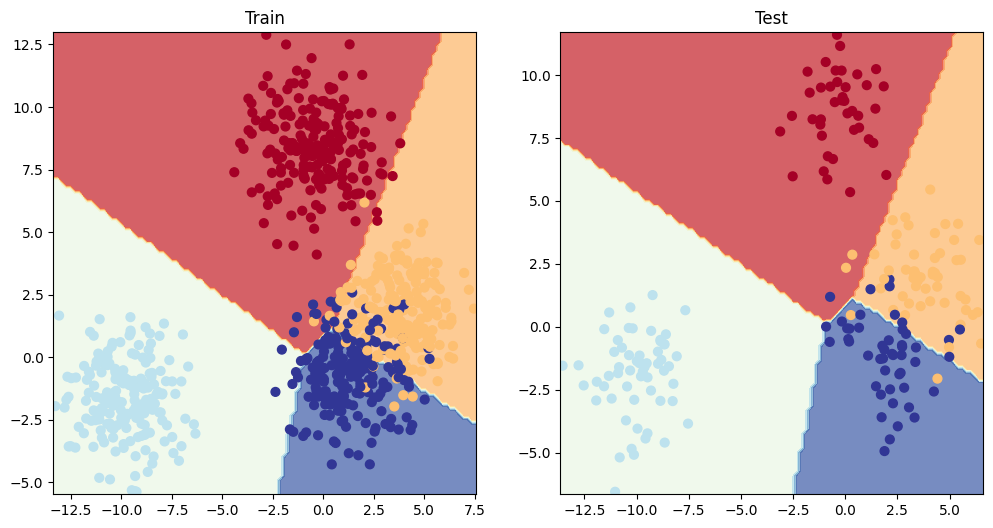

In [66]:
plt.figure(figsize= (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")

plot_decision_boundary(model4, XBlobTrain, yBlobTrain)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model4, XBlobTest, yBlobTest)

In [67]:
# Taking out the non-linear data layers doesn't change anything as the data is linearly separable, meaning that straight lines can be drawn to separate the data

More Classification Metrics
* Accuracy (out of 100 samples how many does the model get right)
* Precision
* Recall
* F1-Score
* Confusion Matrix
* Classification Report

Precision Recall Trade Off: As Precision is increased Recall is lowered.

Using torchmeterics or scikit learn